In [ ]:
import tensorflow.keras as keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import resnet50
import os
import numpy as np
import requests
import json
import time
from PIL import Image, ImageEnhance
import io
from io import BytesIO
import sklearn
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
import pyarrow
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import tensorflow as tf

Funções necessárias

In [ ]:
#printa a imagem
def show_get_images(image_url):
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))
    img.resize((224,224))
    img.show()

def get_image_bytes(image_url):
    response = requests.get(image_url)
    # img = Image.open(BytesIO(response.content))
    return response.content

#processamento da imagem 
def image_preprocessing(img_bytes, return_body=True):
    try:
        img = Image.open(BytesIO(img_bytes)).convert("RGB")
        image = tf.image.resize(img, [224, 224])
        image = tf.expand_dims(image, axis=0)
        image = resnet50.preprocess_input(image)
        if return_body:
#             body = img.tolist()
            return image
        else:
            return image
    except Exception as e:
        print(e)
        return None

#obtem a lista de embeddings das imgs
def get_features(img_bytes):
    res = image_preprocessing(img_bytes, return_body=False)
    if res is not None:
        preds = model.predict(res, verbose=0)
        return preds
    else: 
        return list(list())

Analisando datasets e setando colunas

In [ ]:
df = pd.read_csv("styles.csv", error_bad_lines=False)
df_image = pd.read_csv("images.csv")

df['img_path'] = df_image['link'].apply(lambda x: x)
# df = df.sample(frac=0.75)
df.shape

<ipython-input-6-0f0542ad9874>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv("styles.csv", error_bad_lines=False)
Skipping line 7399: expected 10 fields, saw 11
Skipping line 7939: expected 10 fields, saw 11
Skipping line 9026: expected 10 fields, saw 11
Skipping line 10264: expected 10 fields, saw 11
Skipping line 10427: expected 10 fields, saw 11
Skipping line 10905: expected 10 fields, saw 11
Skipping line 11373: expected 10 fields, saw 11
Skipping line 11945: expected 10 fields, saw 11
Skipping line 14112: expected 10 fields, saw 11
Skipping line 14532: expected 10 fields, saw 11
Skipping line 15076: expected 10 fields, saw 12
Skipping line 29906: expected 10 fields, saw 11
Skipping line 31625: expected 10 fields, saw 11
Skipping line 33020: expected 10 fields, saw 11
Skipping line 35748: expected 10 fields, saw 11
Skipping line 35962: expected 10 fields, saw 11
Skippi

(44426, 11)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44426 entries, 0 to 44425
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44426 non-null  int64  
 1   gender              44426 non-null  object 
 2   masterCategory      44426 non-null  object 
 3   subCategory         44426 non-null  object 
 4   articleType         44426 non-null  object 
 5   baseColour          44411 non-null  object 
 6   season              44405 non-null  object 
 7   year                44425 non-null  float64
 8   usage               44109 non-null  object 
 9   productDisplayName  44419 non-null  object 
 10  img_path            44426 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 3.7+ MB


In [ ]:
df_teste = df.sample(frac=0.25, random_state=42)
df_teste = df_teste[df_teste['img_path'] != "undefined"]


df_treino = df.drop(df_teste.index)
duplicated_rows_treino = df_treino[df_treino.duplicated(['img_path'], keep=False)]
df_treino = df_treino.drop(duplicated_rows_treino.index)

print(df.shape)
print(df_treino.shape)
print(df_teste.shape)

(44426, 11)
(33314, 11)
(11106, 11)


Inicializa o modelo ResNet50 para fazer os embbedings

In [ ]:
model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(224,224,3))

Obtem a lista de paths das imgs e o embedding do dataset de treino

In [ ]:
object_keys = df_treino.img_path.to_list()

treino_features_list = []
start = time.time()
counter=0
for obj_img in object_keys:
    if counter % 1000 ==0:
        print(f"-------{counter}/{df_treino.shape[0]}-------")
        print(f"-------{time.time() - start}-------")
    image_bytes = get_image_bytes(obj_img)
    features = get_features(image_bytes)
    treino_features_list.append(features)
    counter= counter + 1

time_final = time.time() - start
print(f"tempo de {time_final}")
print(f"Media de tempo por embedding: {time_final/len(object_keys)}")

In [ ]:
len(object_keys)

33320

In [ ]:
df_treino['embedding'] = list(map(lambda x: x[0] if len(x) > 0 else [], treino_features_list))
df_treino=df_treino[df_treino['embedding'].apply(lambda x : len(x))>0]
df_treino.to_parquet(path='embedding_training_set.parquet')

Treinando o KNN com os embeddings do treino

In [ ]:
X = np.vstack(df_treino["embedding"].values)
y = df_treino['img_path'].values

In [ ]:
# Utilizando distancia de cosenos
neigh = KNeighborsClassifier(n_neighbors=10, metric="cosine")
neigh.fit(X, y)
neigh.n_samples_fit_

Gerando os embeddings de teste

In [ ]:
object_keys = df_teste.img_path.to_list()

teste_features_list = []
start = time.time()
counter=0
for obj_img in object_keys:
    if counter % 100 ==0:
        print(f"-------{counter}/{df_teste.shape[0]}-------")
        print(f"-------{time.time() - start}-------")
    image_bytes = get_image_bytes(obj_img)
    features = get_features(image_bytes)
    teste_features_list.append(features)
    counter= counter + 1

print(f"tempo de {time.time() - start}")

In [ ]:
df_teste['embedding'] = list(map(lambda x: x[0] if len(x) > 0 else [], teste_features_list))
df_teste=df_teste[df_teste['embedding'].apply(lambda x : len(x))>0]
df_teste.to_parquet(path='embedding_training_set.parquet')

Encontrando a vizinhança da imagem de entrada

In [ ]:
found_neighbors = neigh.kneighbors(list(df_teste['embedding'].values))

In [ ]:
df_teste['neighbor'] = [i for i in found_neighbors[1]]
df_teste['index'] = pd.Series(list(range(df_teste.shape[0])))

In [ ]:
df_teste.drop(columns= ["index"], inplace=True)
# df_teste.columns

In [ ]:
path_dict={}

for idx, path in enumerate(df_treino['img_path'].values):
    path_dict[idx]= path

In [ ]:
df_teste['neigh_embbeding'] = df_teste['neighbor'].apply(lambda x: list(map(lambda y: path_dict[y], x)))

In [ ]:
df_teste.head(5)

id gender masterCategory subCategory  articleType baseColour  \
6497   42350  Women        Apparel  Bottomwear     Leggings      Black   
38684  29041    Men        Apparel  Bottomwear  Track Pants  Navy Blue   
24228   7958    Men        Apparel     Topwear      Tshirts       Blue   
17822  42238  Women        Apparel     Topwear       Tunics       Grey   
42160  36312   Boys        Apparel     Topwear      Tshirts  Navy Blue   

       season    year   usage                       productDisplayName  \
6497   Summer  2012.0  Casual      Flying Machine Women Black Leggings   
38684  Summer  2012.0  Sports         ADIDAS Men Navy Blue Track Pants   
24228    Fall  2011.0  Casual     Puma Men's Tech Graphic Blue T-shirt   
17822  Summer  2012.0  Casual                   Sepia Women Grey Tunic   
42160  Summer  2012.0  Casual  Mr. Men Boys Mr. Rude Navy Blue T-shirt   

                                                img_path  \
6497   http://assets.myntassets.com/v1/images/style/p...   
38684  http://assets.myntassets.com/v1/images/style/p...   
24228  http://assets.myntassets.com/v1/images/style/p...   
17822  http://assets.myntassets.com/v1/images/style/p...   
42160  http://assets.myntassets.com/v1/images/style/p...   

                                               embedding  \
6497   [0.14692299, 0.45733932, 0.06304771, 0.2894003...   
38684  [0.23630714, 0.36756322, 0.0, 0.099236935, 0.1...   
24228  [1.0496058, 0.0, 1.0478544, 0.5513113, 0.02519...   
17822  [0.13881077, 0.27207264, 0.108685166, 0.0, 0.3...   
42160  [0.27792892, 0.10928835, 0.0, 0.08220138, 0.0,...   

                                                neighbor  \
6497   [817, 163, 787, 254, 588, 957, 844, 656, 1361,...   
38684  [1621, 1106, 924, 585, 1602, 1356, 919, 46, 18...   
24228  [1655, 1360, 1816, 673, 375, 643, 732, 1950, 9...   
17822  [1245, 1339, 1569, 1064, 484, 348, 327, 769, 5...   
42160  [1924, 456, 569, 1077, 1111, 1960, 236, 1929, ...   

                                         neigh_embbeding  
6497   [http://assets.myntassets.com/v1/images/style/...  
38684  [http://assets.myntassets.com/v1/images/style/...  
24228  [http://assets.myntassets.com/v1/images/style/...  
17822  [http://assets.myntassets.com/v1/images/style/...  
42160  [http://assets.myntassets.com/v1/images/style/...

In [ ]:
df_image.head(5)

filename                                               link
0  15970.jpg  http://assets.myntassets.com/v1/images/style/p...
1  39386.jpg  http://assets.myntassets.com/v1/images/style/p...
2  59263.jpg  http://assets.myntassets.com/v1/images/style/p...
3  21379.jpg  http://assets.myntassets.com/v1/images/style/p...
4  53759.jpg  http://assets.myntassets.com/v1/images/style/p...

IMAGEM ORIGINAL


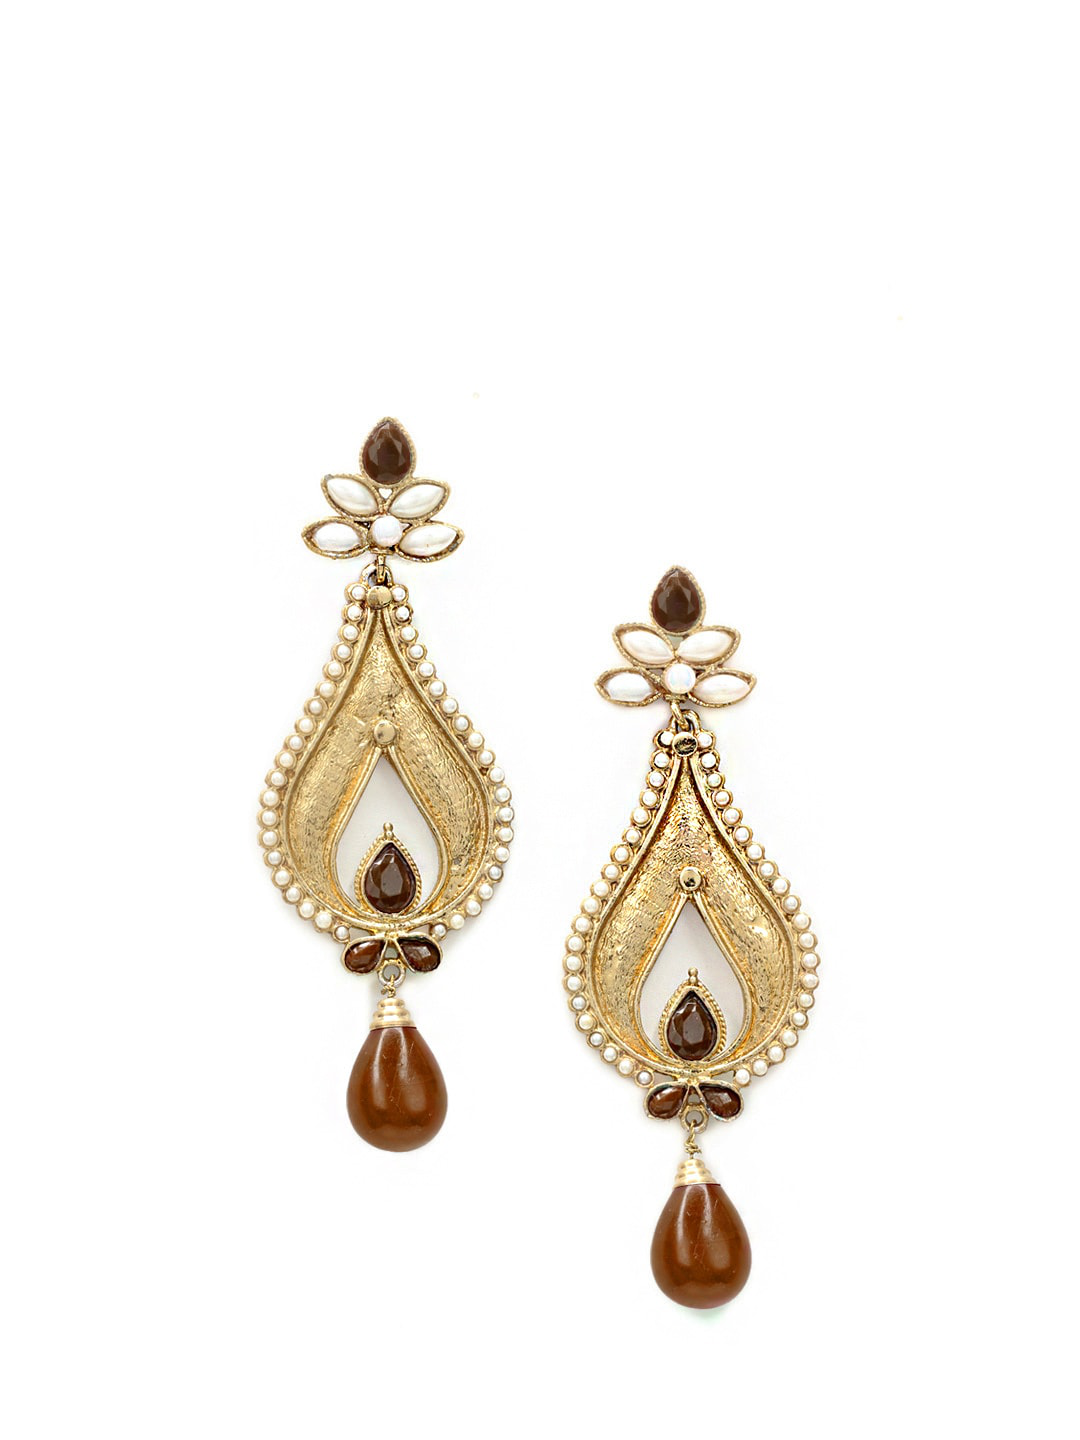

IMAGEM VIZINHA


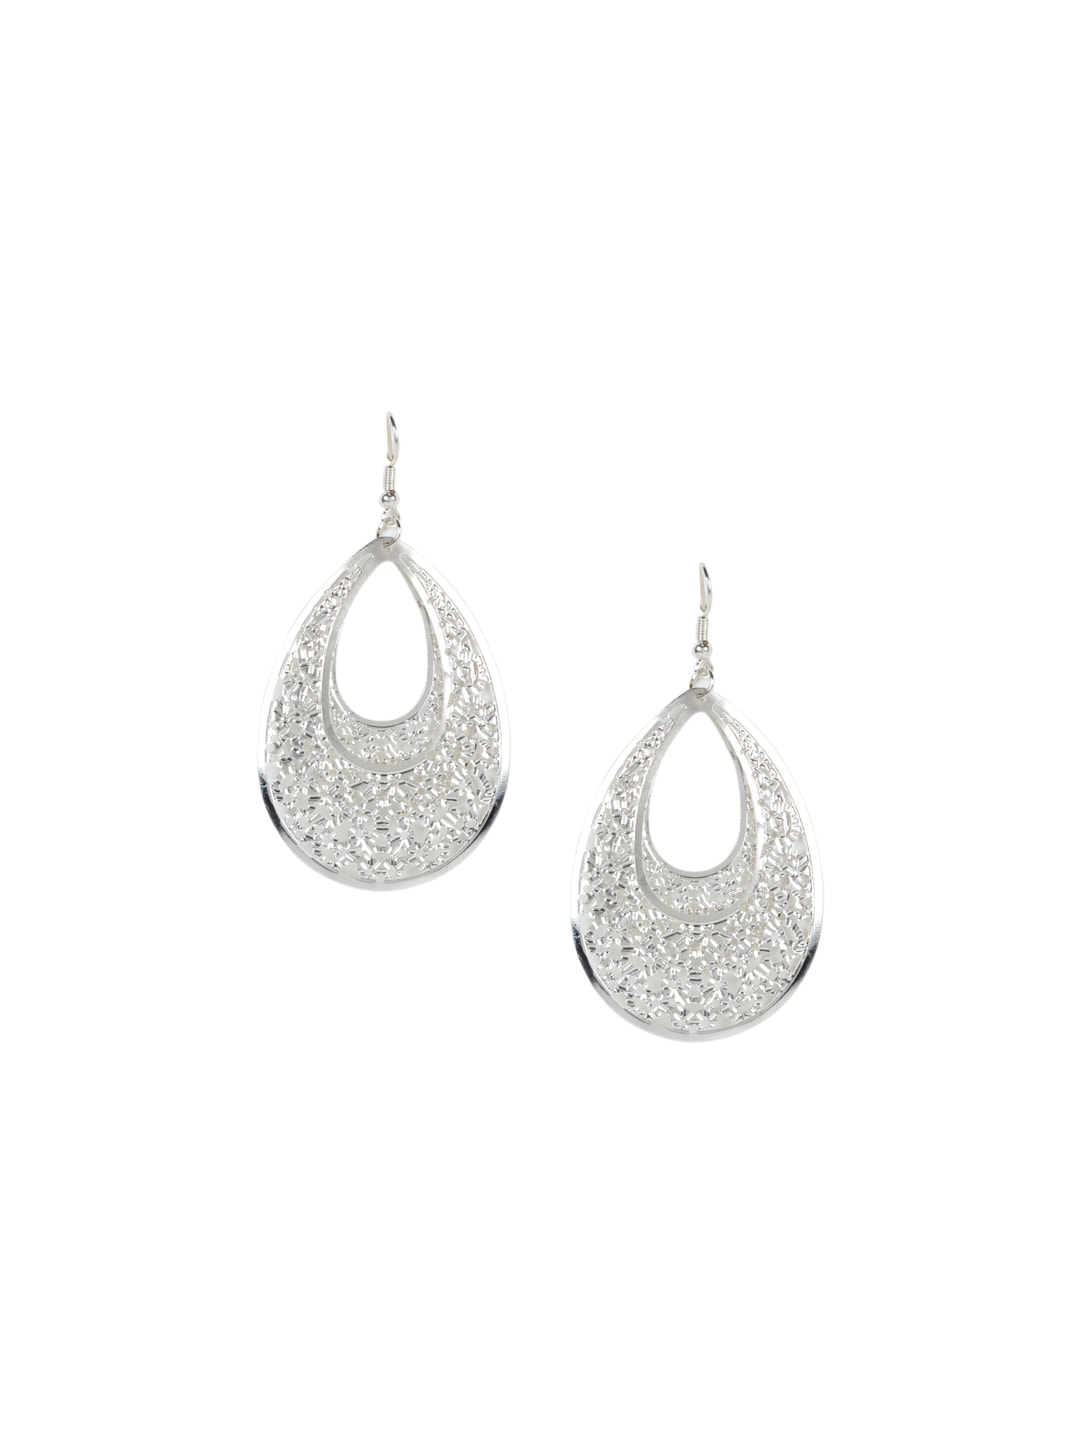

IMAGEM VIZINHA


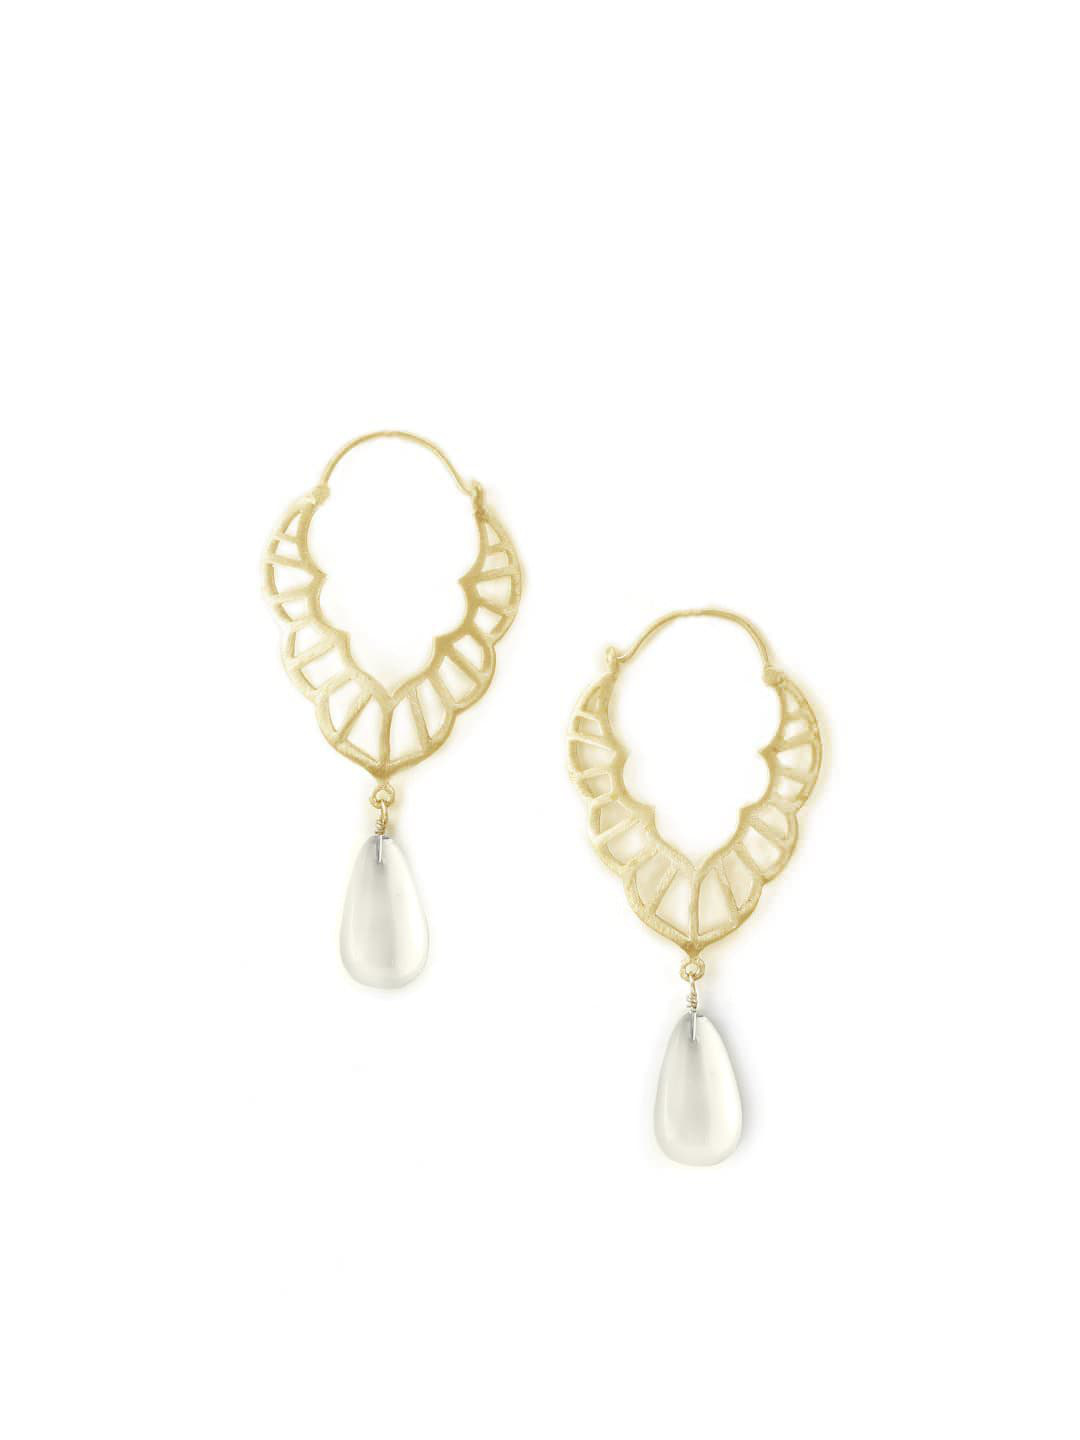

IMAGEM VIZINHA


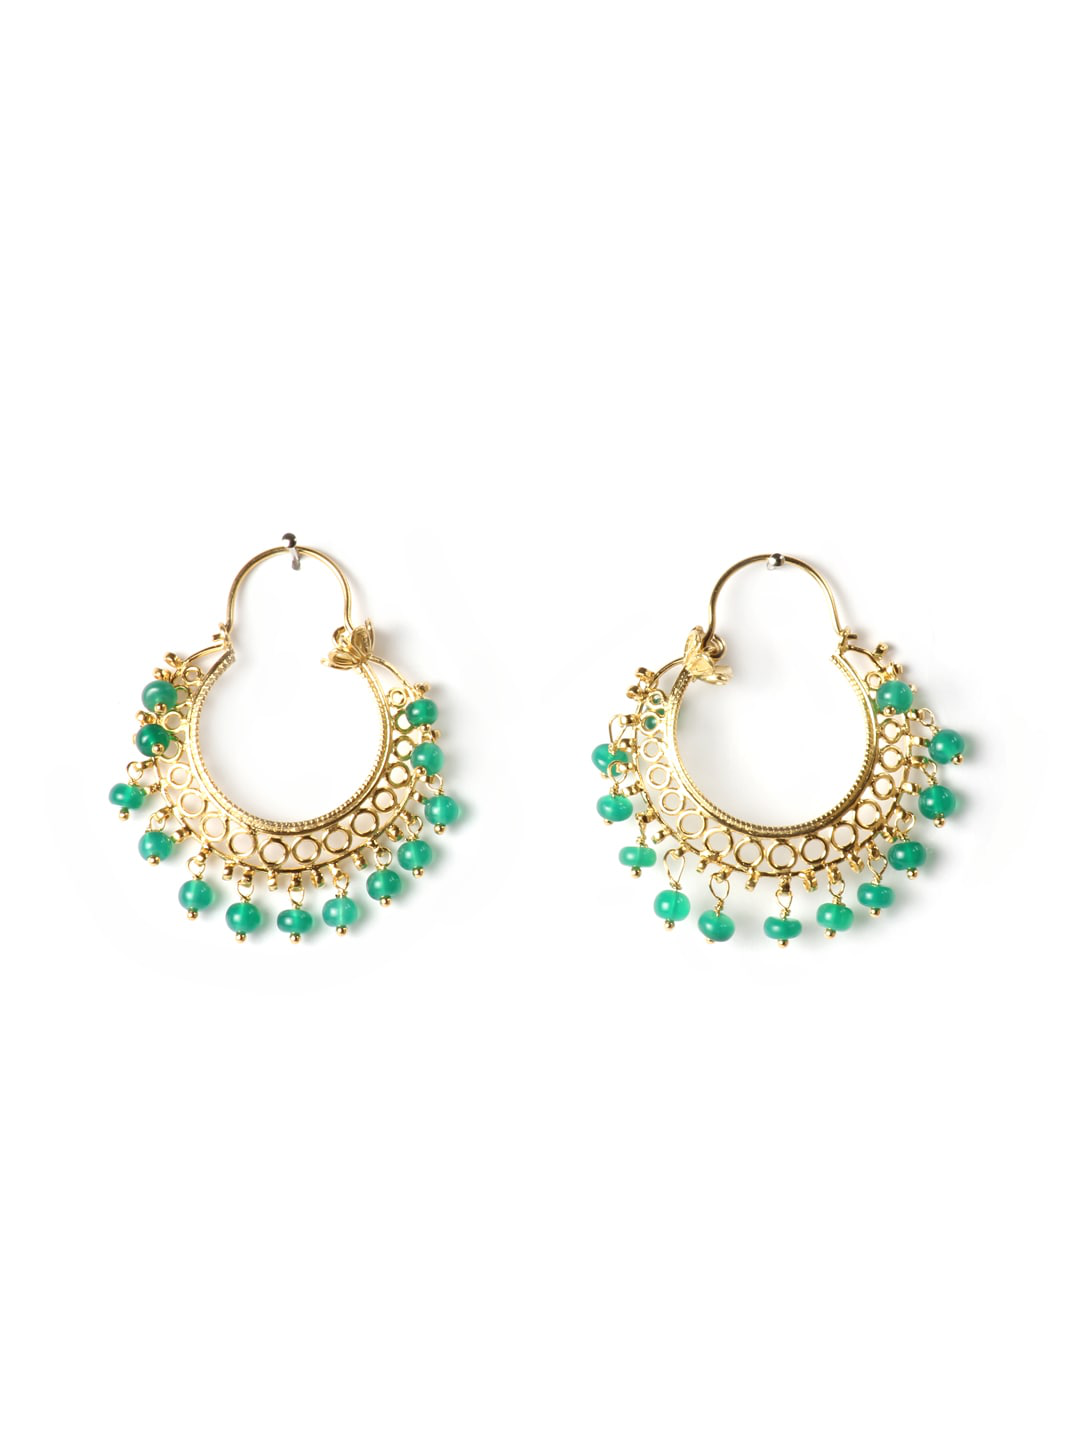

IMAGEM VIZINHA


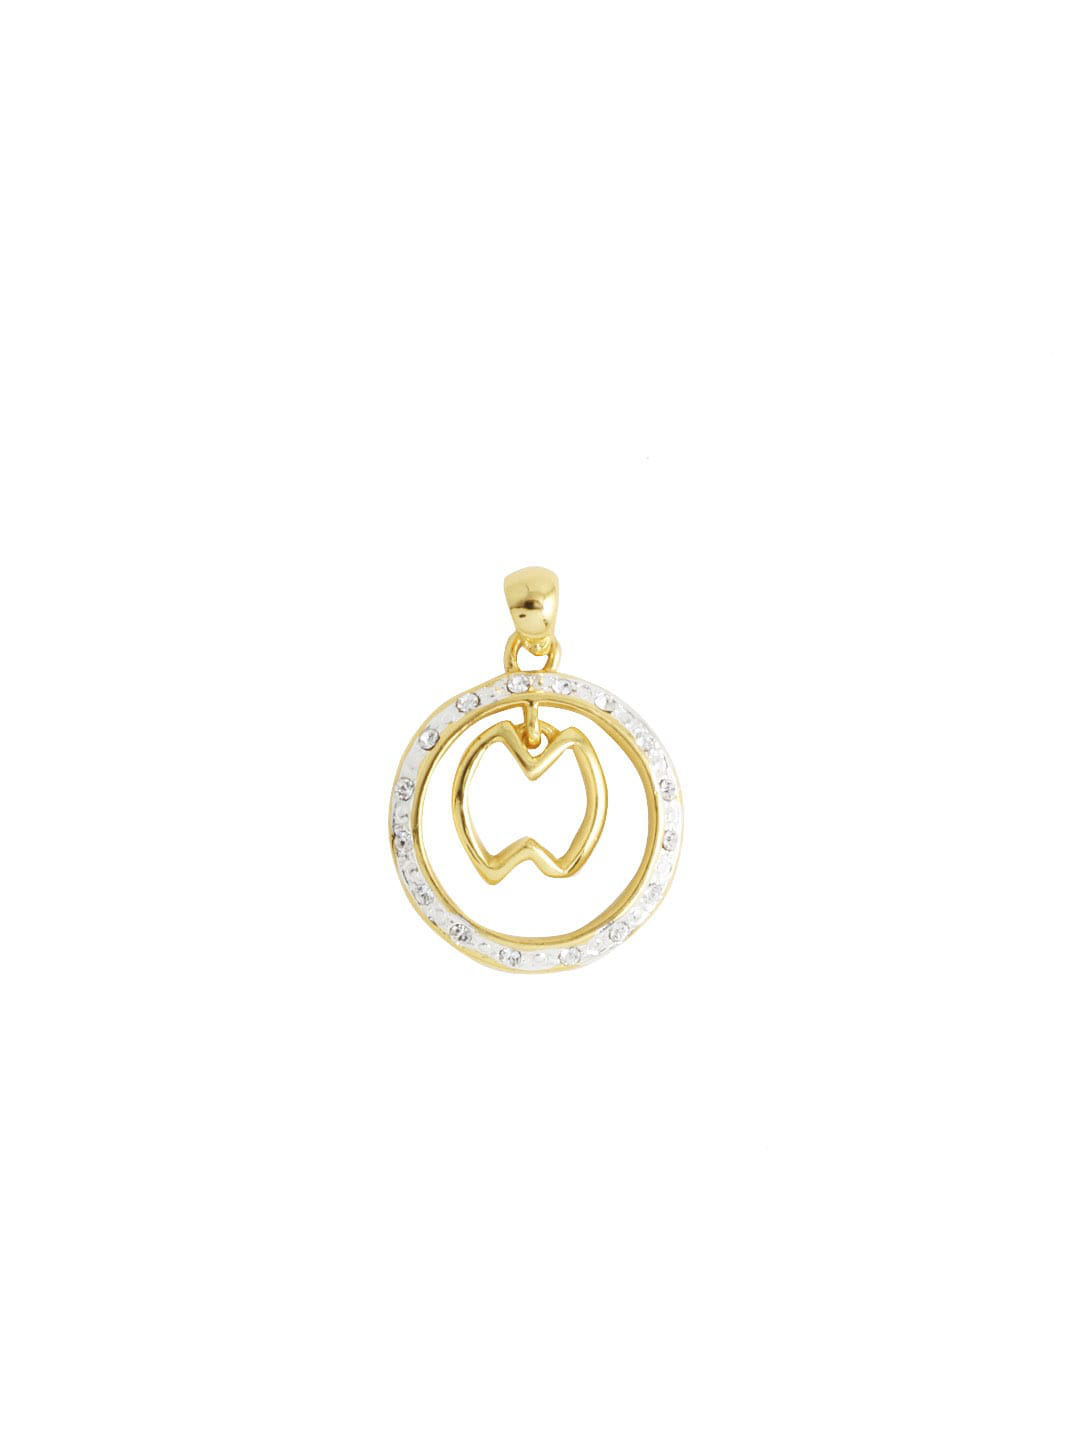

IMAGEM VIZINHA


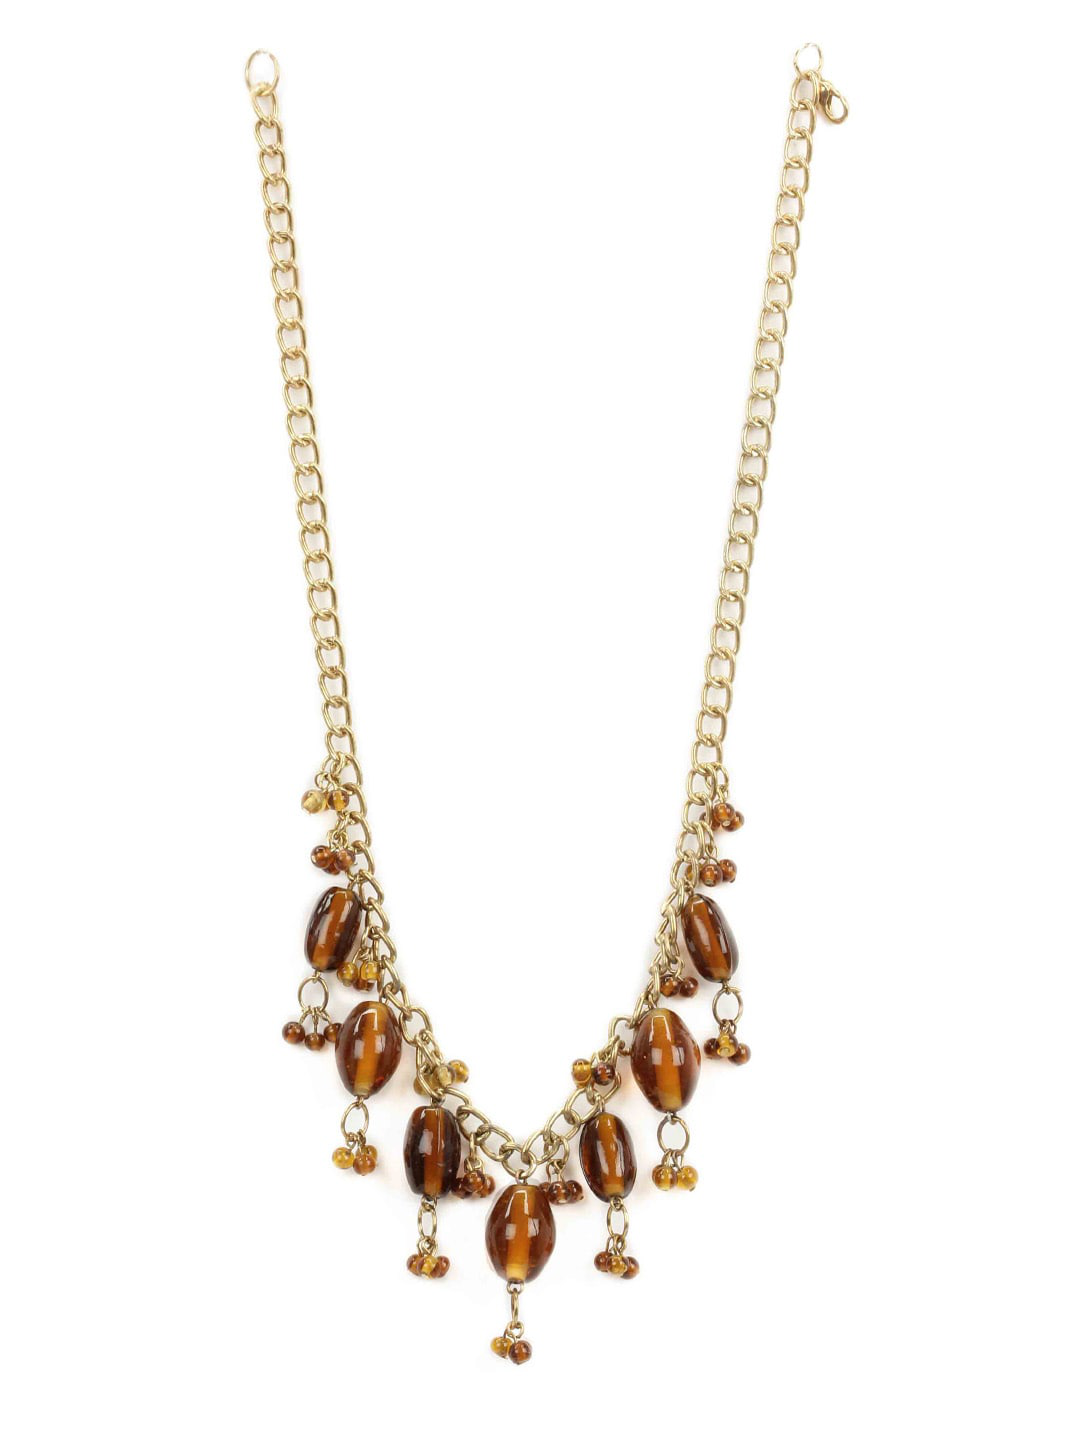

IMAGEM VIZINHA


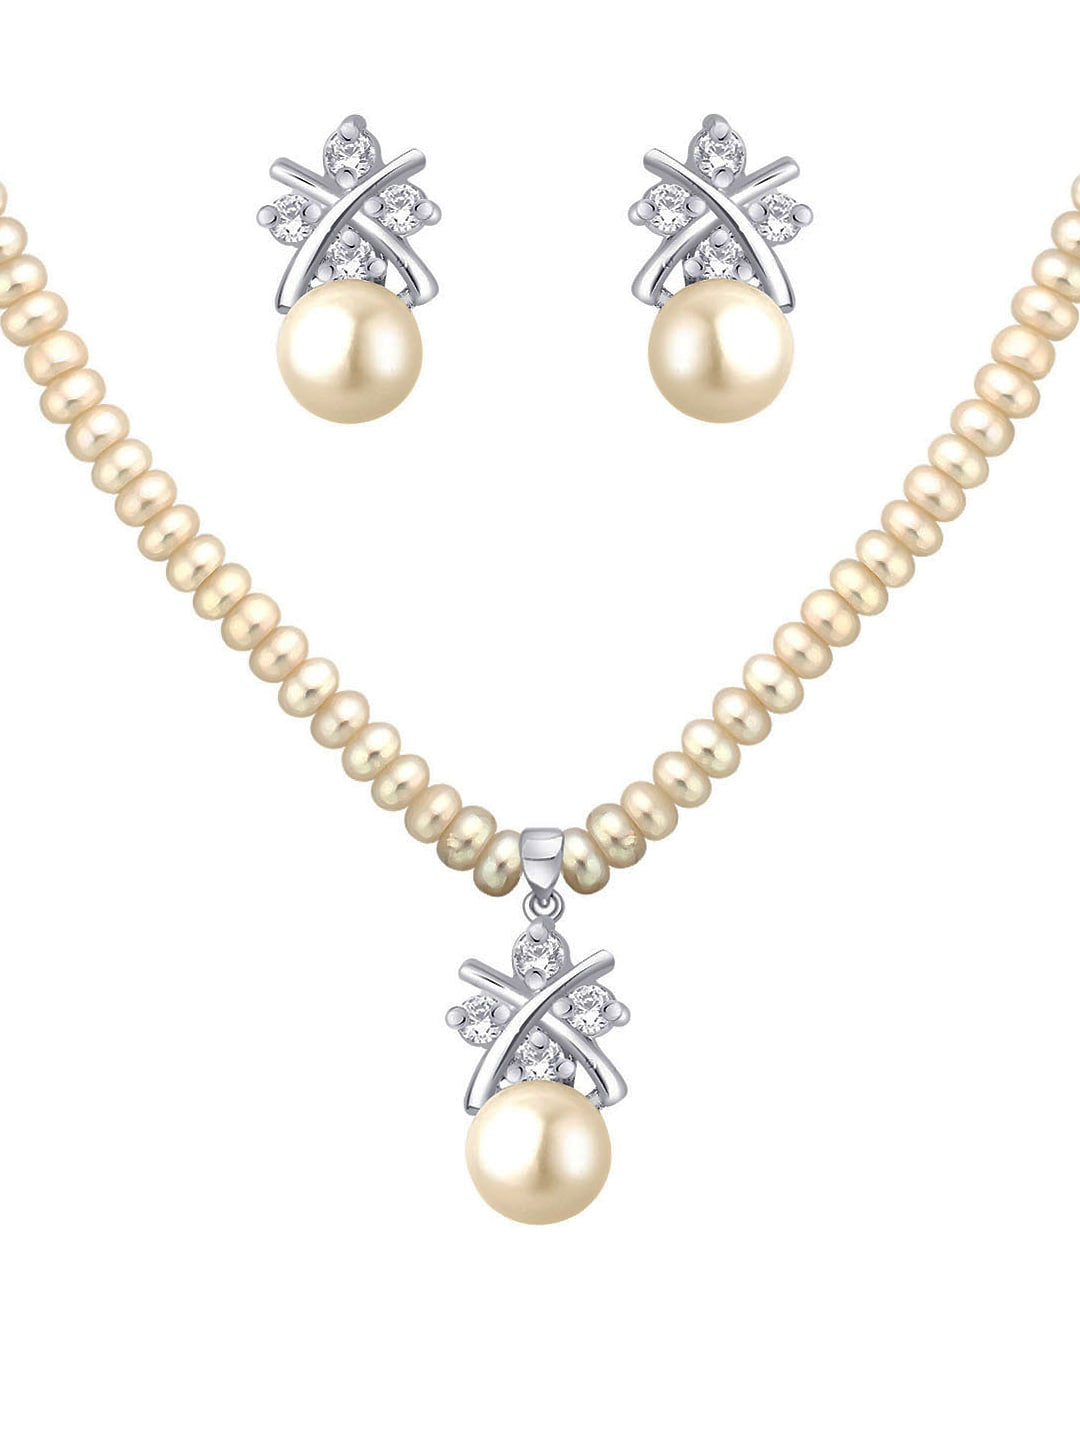

IMAGEM VIZINHA


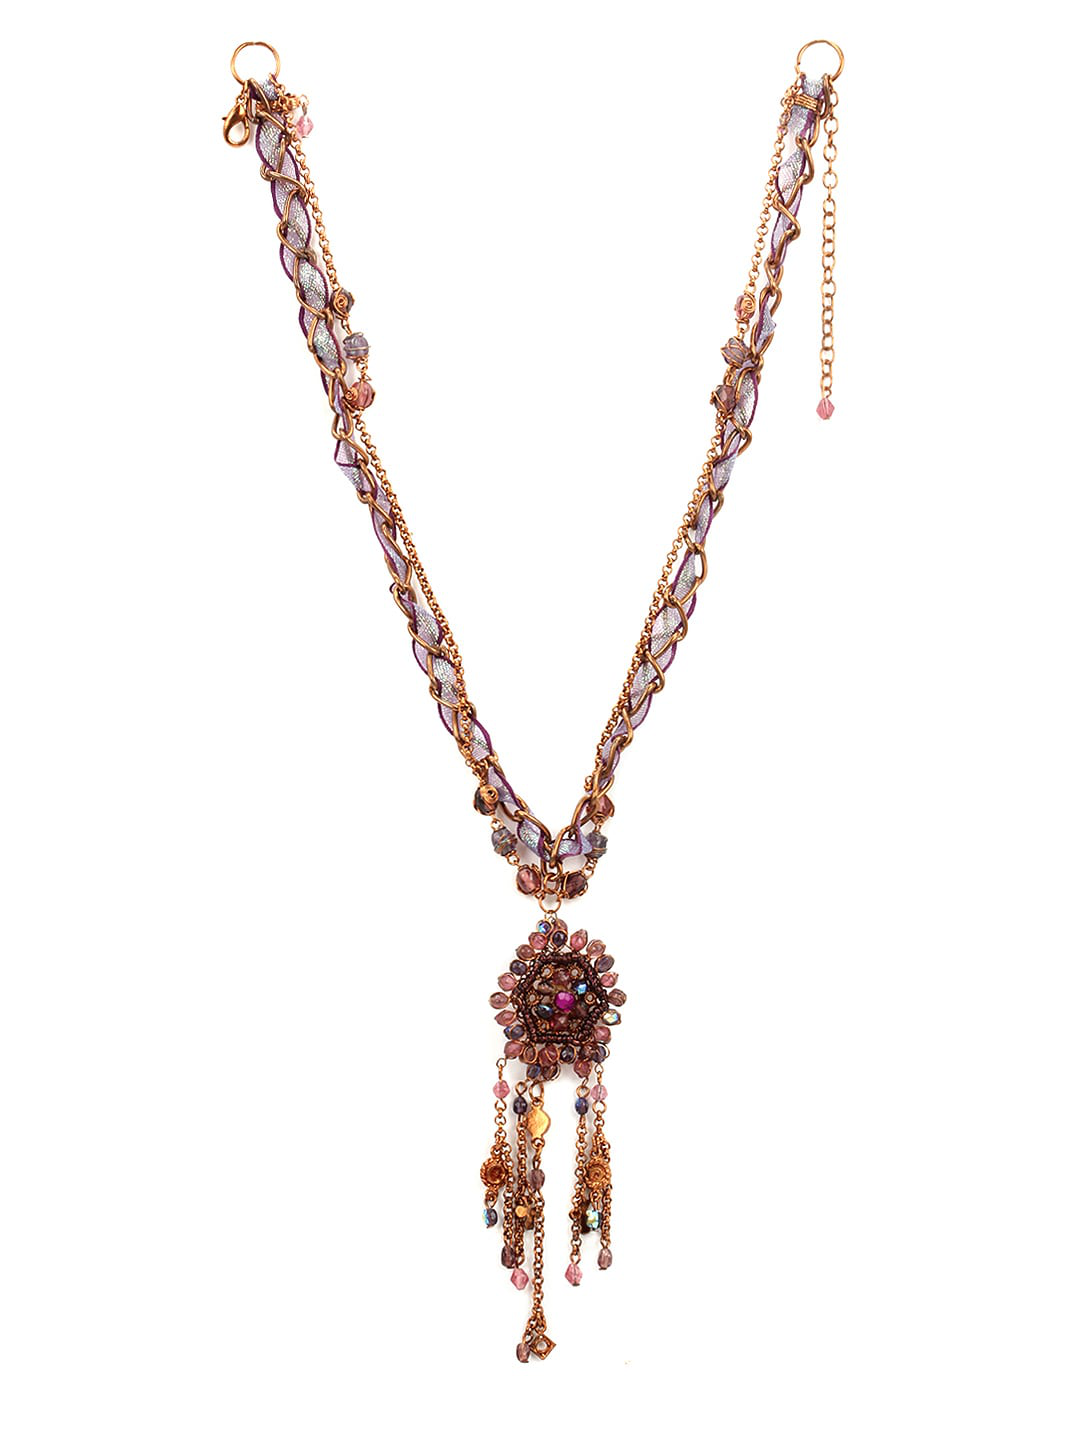

IMAGEM VIZINHA


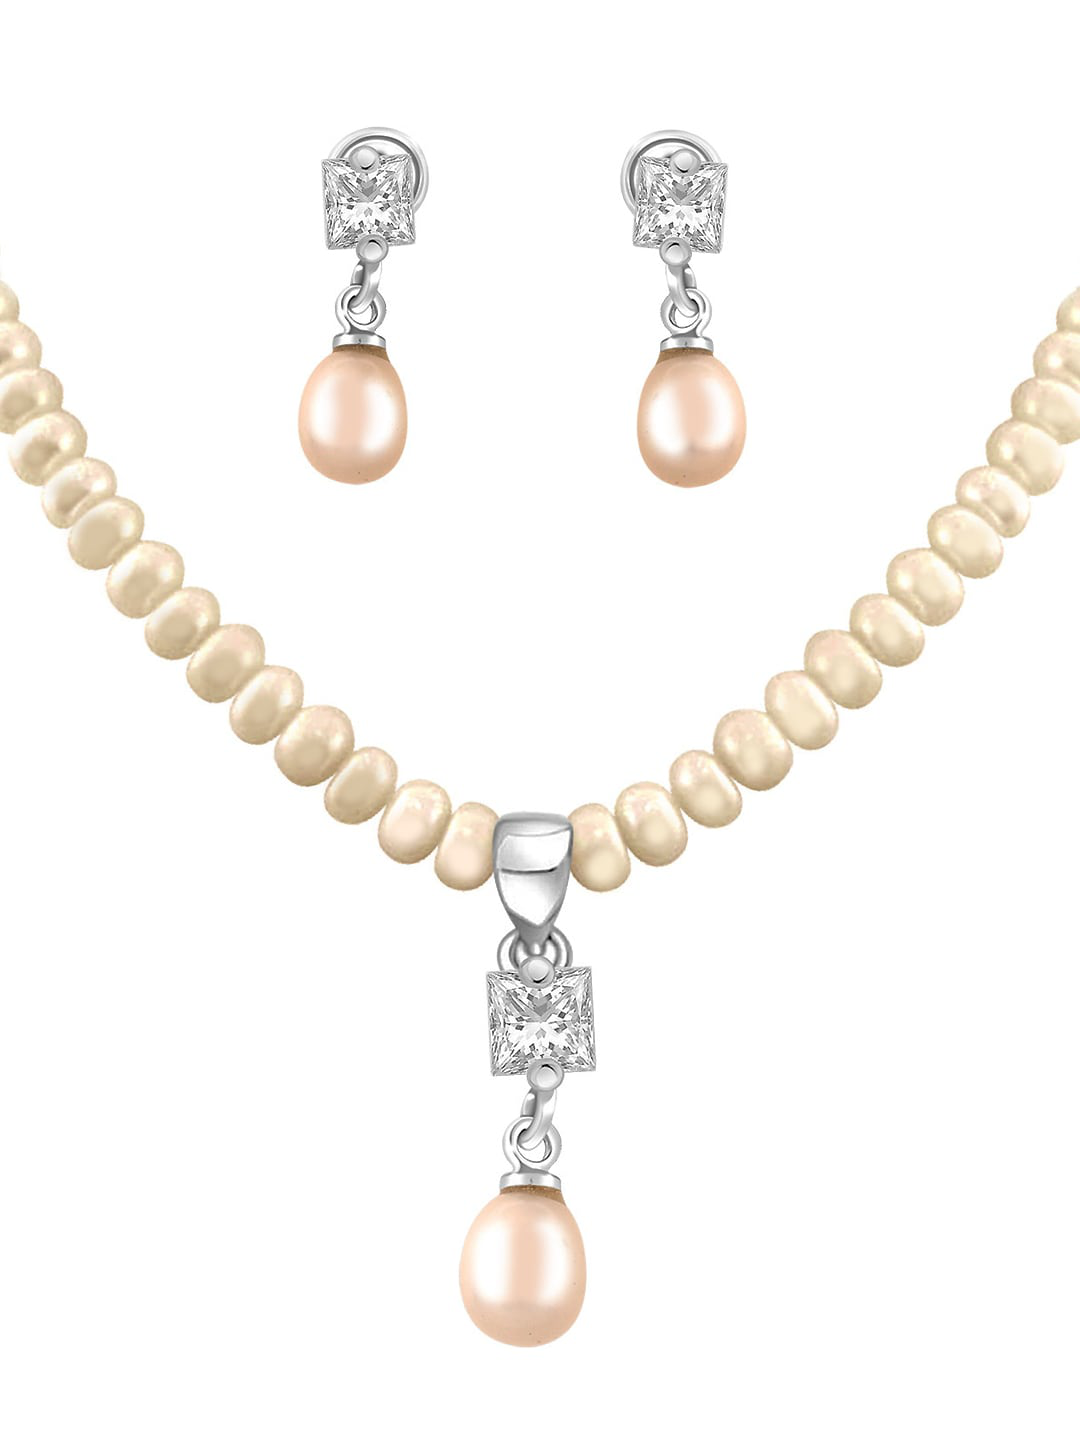

IMAGEM VIZINHA


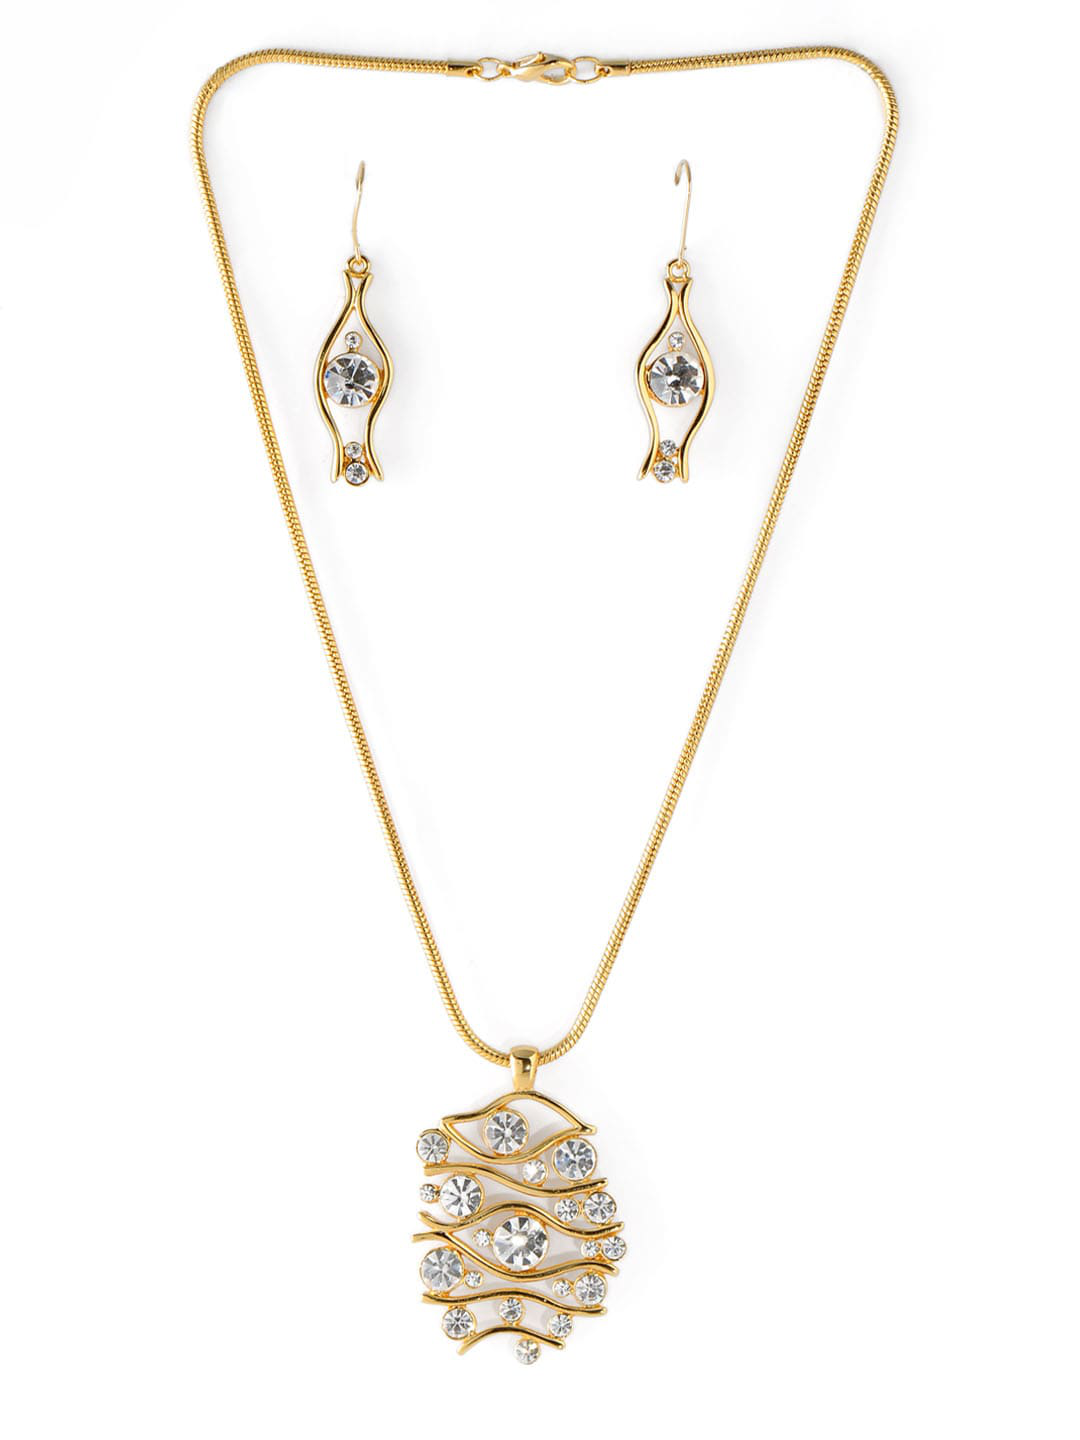

IMAGEM VIZINHA


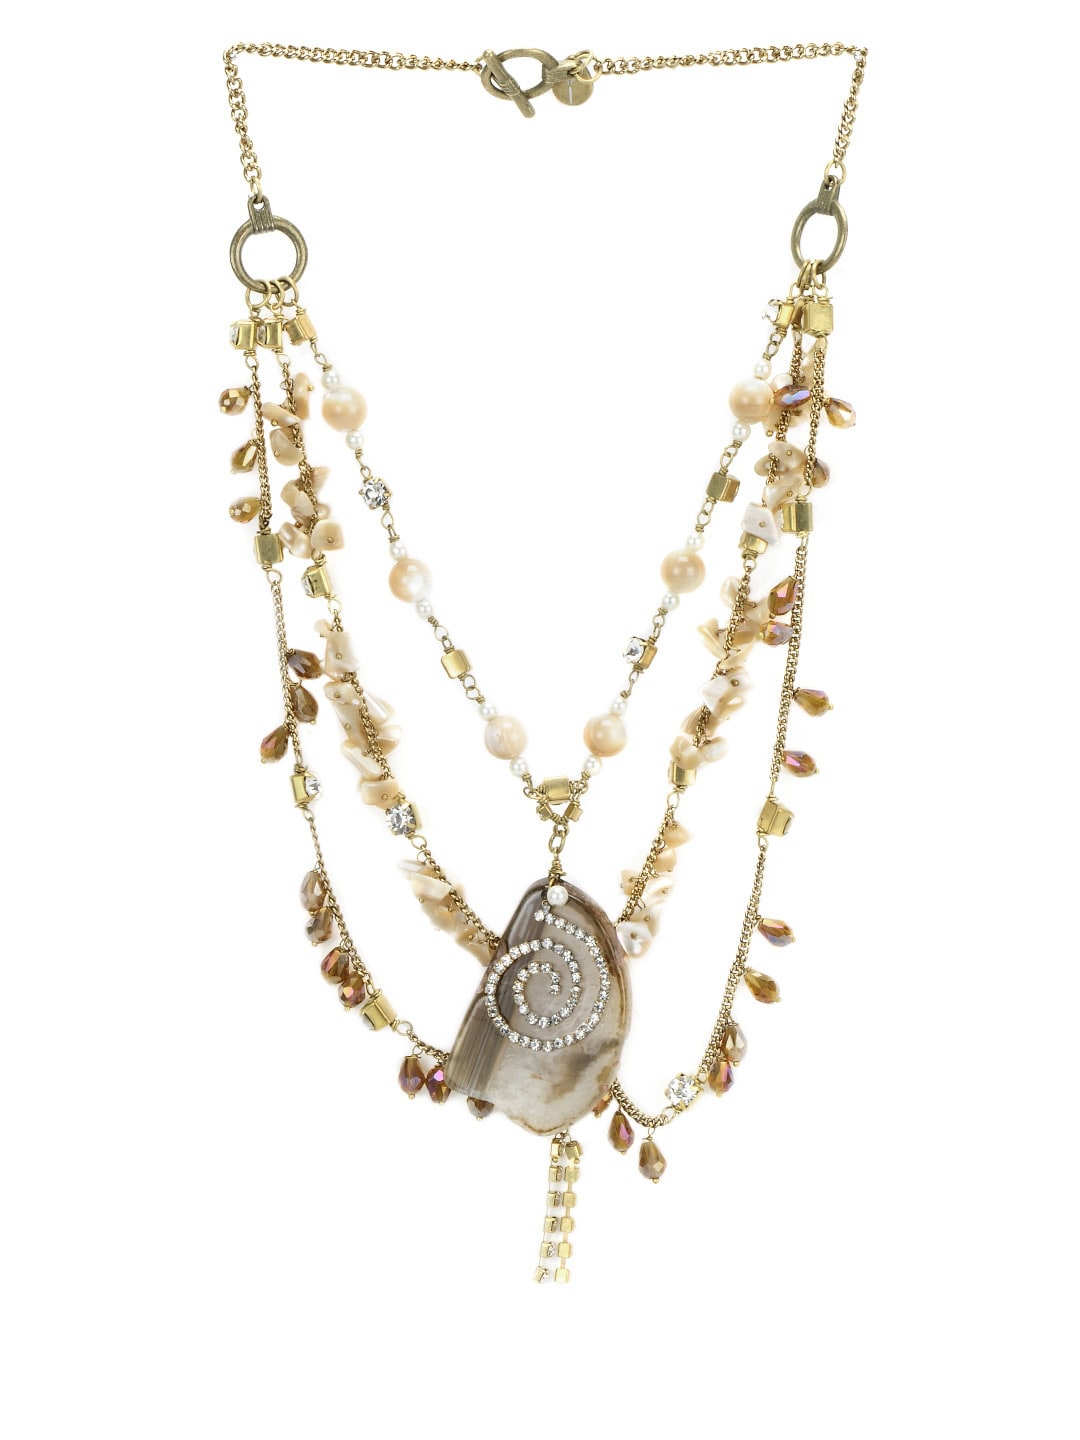

In [ ]:
teste_sample = df_teste.sample(1)
print("IMAGEM ORIGINAL")
show_get_images(teste_sample.img_path.values[0])

for imagem in teste_sample.neigh_embbeding.values[0]:
    print(f"IMAGEM VIZINHA")
    show_get_images(imagem)

In [ ]:
teste_sample.img_path.values[0]

'http://assets.myntassets.com/assets/images/56153/2016/11/25/11480077641881-Colorbar-I-Glide-Glowing-Saphire-Eye-Pencil-010-8991480077641819-1.jpg'

In [ ]:
teste_sample.neigh_embbeding.values[0]

['http://assets.myntassets.com/v1/images/style/properties/3892cb9dff0774f694ea34308089f19d_images.jpg',
 'http://assets.myntassets.com/v1/images/style/properties/American-Tourister-Unisex-Casual-Olive-Backpack3c30a40b38e76a616b0efd2ce5c107d5_images.jpg',
 'http://assets.myntassets.com/v1/images/style/properties/1eef307a865657bad5cfb6eba55e32a4_images.jpg',
 'http://assets.myntassets.com/v1/images/style/properties/AMERICAN-TOURISTER-Unisex-Backpacks_cc3ef6c219d935da71960d1d25556317_images.jpg',
 'http://assets.myntassets.com/v1/images/style/properties/American-Tourister-Unisex-Purple-Backpack_f2cb975b51576d9a927d07b8f5c2cdff_images.jpg',
 'http://assets.myntassets.com/v1/images/style/properties/146db0db763bb7d165b8428601e9dcd1_images.jpg',
 'http://assets.myntassets.com/v1/images/style/properties/43a6a9c2bb1ef378cd12817e0a548011_images.jpg',
 'http://assets.myntassets.com/v1/images/style/properties/American-Tourister-Unisex-Black-Backpack_c59a409a4e959afaaa36b09f9223dae1_images.jpg',
 '